# Setup

In [83]:
# --- Basic Utilities ---
import datetime as dt
import logging
import math
import os
import re
import sys
import time
import warnings
import json
import functools
import time
from pathlib import Path

# --- Data Manipulation ---
import numpy as np
import pandas as pd
from prefect.deployments.steps import pip_install_requirements

# --- Validation ---
from pydantic import BaseModel, Field, ValidationError

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Math

# --- Console Formatting ---
from colorama import Fore, Style

# --- Logging Framework ---
from loguru import logger
import uuid

# --- MLflow for Experiment Tracking ---
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.data import from_pandas
from mlflow.models.signature import infer_signature

# --- ONNX Runtime (Optional) ---
import onnx
import onnxruntime as ort

# Add the below onnx code to FastAPI for deployment
# @app.on_event("startup")
# def load_model():
#     global session
#     session = ort.InferenceSession(
#         "model.onnx",
#         providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
#     )


# --- Scientific Computation ---
import scipy as sp
import sympy as sym
from plotly.data import experiment

# --- Scikit-Learn ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder
)

from sklearn.linear_model import (
    LogisticRegression, ElasticNet, Ridge, Lasso
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms

# --- Joblib for Model Serialization ---
import joblib

# --- Optional: Config Frameworks (commented) ---
# from omegaconf import OmegaConf
# import hydra

# --- Mlflow Env ---
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "false"

# --- PyTorch Runtime Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
print(f"[INFO] PyTorch version: {torch.__version__}")
torch.set_num_threads(32)

[INFO] Using device: cuda
[INFO] PyTorch version: 2.6.0+cu124


## Logger

In [84]:
# --- MLflow Experiment Setup ---
experiment_name = "fashion_mnist_cnn"
mlflow.set_experiment(experiment_name)

# --- Store requirements.txt as obj for logging ref
with open('/mnt/git/requirements.txt') as f:
    requirements = f.read().splitlines()

# --- Init MLflow Run ---

# kill unclosed run if exists
if mlflow.active_run():
    mlflow.end_run()

run = mlflow.start_run()

# --- Logging Initialization ---

# Create log directory for the experiment
log_dir = Path("/mnt/mls/logs") / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

# Define log file path
log_file = log_dir / f"train_{experiment_name}.log"
timestamp = str(dt.datetime.now(dt.timezone.utc).strftime("%Y_%m_%d_%H%M%S"))
run_id = run.info.run_id

logger.remove()

logger = logger.bind(run_id=run_id)
logger = logger.bind(run_id=run_id, timestamp=timestamp)

# File logging with daily rotation and compression
logger.add(
    str(log_file),  # Path to the log file (must be a string, not a Path object)

    format="{extra[timestamp]} | {level} | {extra[run_id]} | {name}:{function}:{line} | {message}",
    # Format of each log line:
    # {time}     - Timestamp (YYYY-MM-DD HH:MM:SS.mmm)
    # {level}    - Log level (INFO, DEBUG, etc.)
    # {name}     - Module name (e.g., 'helper' from 'helper.py')
    # {function} - Name of the function that emitted the log
    # {line}     - Line number where logger was called
    # {message}  - The actual message logged

    level="DEBUG",  # Minimum log level for this handler (includes INFO, WARNING, ERROR, etc.)
    rotation="00:00",  # Automatically rotate log file when "00:00" for daily rotation
    retention="14 days",  # Keep rotated log files for 14 days, then delete them automatically
    compression="zip",  # Compress rotated log files using ZIP format to save space
    enqueue=True,  # Use multiprocessing-safe queue to log from multiple threads/processes safely
    backtrace=True,  # Show full stack trace (even outside of the except block) if an error occurs
    diagnose=False,  # Disable automatic introspection of variables in the traceback (safer for production)
    mode="a",  # Open the log file in append mode (ensures logs aren’t overwritten on script restart)
    filter=lambda record: record["extra"].get("run_id") == run_id  # Optional, if multiple run_ids used
)


def log_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logger.info(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result

    return wrapper


logger.info("Logger initialized (mlflow.start_run()).")

Framework | Preferred format
 - PyTorch | NCHW
 - TensorFlow | NHWC
 - OpenCV / PIL | HWC (no batch)

### CNN Layer Summary

| **Layer / Hyperparameter**         | **What it does**                                                                 | **Typical values / Notes**                                                                                   |
|-----------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **Input image(s)**                | Target images you'd like to discover patterns in                                | Any image — e.g., a photo or video frame                                                                     |
| **Input layer**                   | Prepares images for the model                                                   | `input_shape = [batch, height, width, channels]` *(TensorFlow)*<br>`[batch, channels, height, width]` *(PyTorch)* |
| **Convolution layer**            | Learns important image features                                                 | `torch.nn.Conv2d()` or `torch.nn.ConvXd()`                                                                   |
| **Hidden activation**            | Adds non-linearity to learned features                                          | Common: `torch.nn.ReLU()`                                                                                    |
| **Pooling layer**                | Downsamples learned feature maps                                                | `torch.nn.MaxPool2d()` or `torch.nn.AvgPool2d()`                                                              |
| **Output (linear) layer**        | Maps features to final class logits                                             | `torch.nn.Linear(out_features=num_classes)`<br>e.g., 3 for pizza/steak/sushi                                |
| **Output activation**            | Converts logits to prediction probabilities                                     | `torch.sigmoid()` *(binary)*<br>`torch.softmax()` *(multiclass)*                                            |


4# Computer visions libraries in PyTorch

* [`torchvision`](https://pytorch.org/vision/stable/index.html) - Base library for PyTorch computer vision
* [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) - get datasets and data loading functions for computer vision here
* [`torchvision.models`](https://pytorch.org/vision/stable/models.html) - get pretrained computer vision models that you can leverage for your own problems
* [`torchvision.transforms`](https://pytorch.org/vision/0.11/transforms.html) - functions for manipulating your vision data (images) to be suitable for use with an ML model
* [`torch.utils.data.Dataset and torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html) - Creates a Python iterable over a dataset

# Dataset

In [85]:
train_data = datasets.FashionMNIST(
    root="/mnt/mls/data",  # where to download the data?
    train=True,  # do we want the training dataset?
    download=True,  # do we want to download yes/no?
    transform=transforms.ToTensor(),  # how do we want to transform the data
    target_transform=None  # how do we want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root="/mnt/mls/data",  # where to download the data?
    train=False,  # do we want the training dataset?
    download=True,  # do we want to download yes/no?
    transform=transforms.ToTensor(),  # how do we want to transform the data
    target_transform=None  # how do we want to transform the labels/targets
)

In [86]:
len(train_data), len(test_data)

(60000, 10000)

In [87]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /mnt/mls/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [88]:
image, label = train_data[0]

In [89]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [90]:
label

9

In [91]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [92]:
class_to_idx = train_data.class_to_idx

In [93]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [94]:
image.shape

torch.Size([1, 28, 28])

# Visualizing our Data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Label: 9')

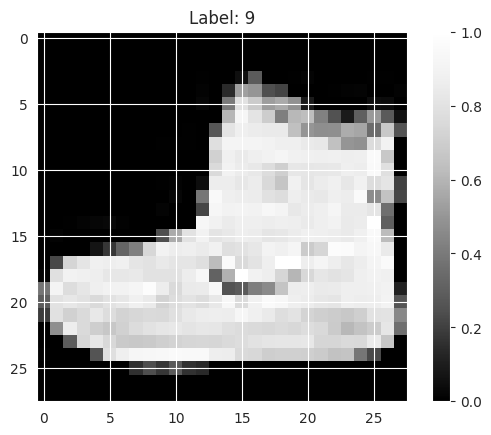

In [95]:
print(f'Image shape: {image.shape}')
plt.imshow(image.squeeze(), cmap="Greys_r")
plt.colorbar()
plt.title(f'Label: {label}')

In [96]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, 6):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    print(random_idx)

37542
46067
46876
46414
10026


<Figure size 1000x1000 with 0 Axes>

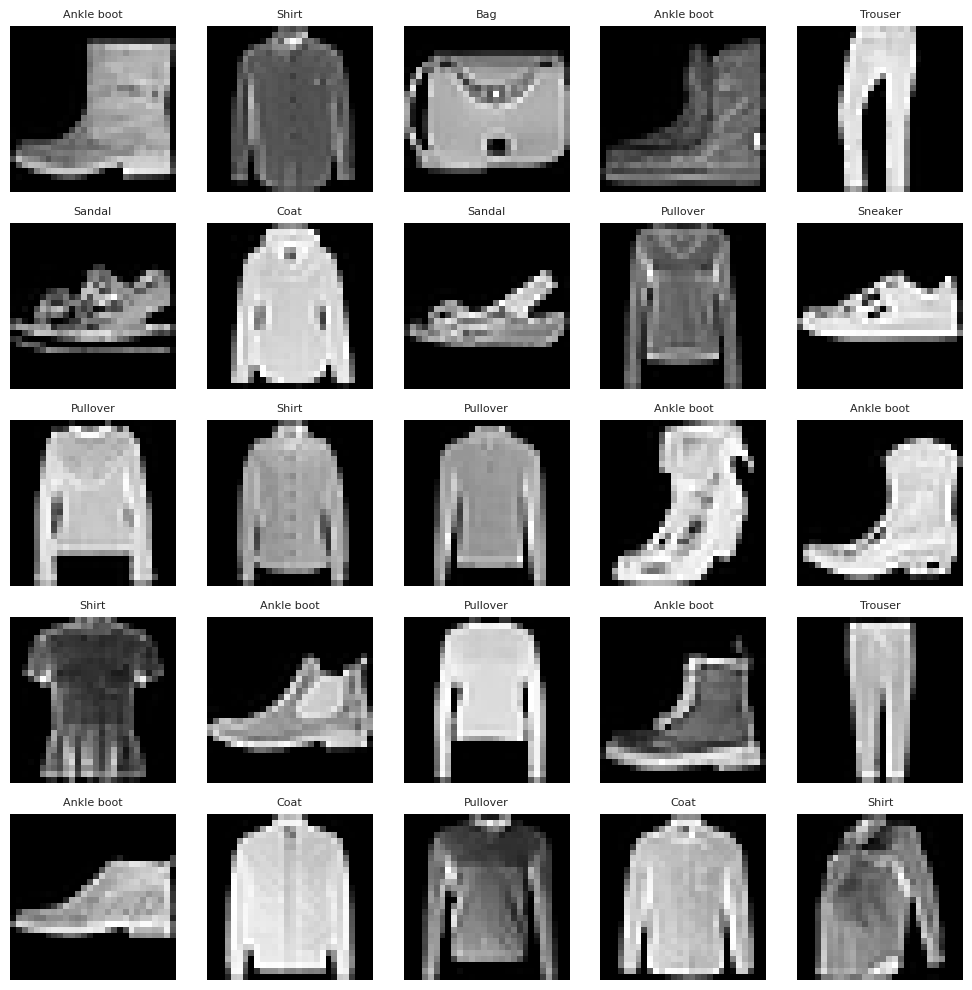

In [97]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [98]:
# set up the batch size hyperparameter
batch_size = 32

# turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [99]:
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {batch_size}')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of {batch_size}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x71afcd332180>, <torch.utils.data.dataloader.DataLoader object at 0x71af38080dd0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [100]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [101]:
# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

In [102]:
random_idx

6

(-0.5, 27.5, 27.5, -0.5)

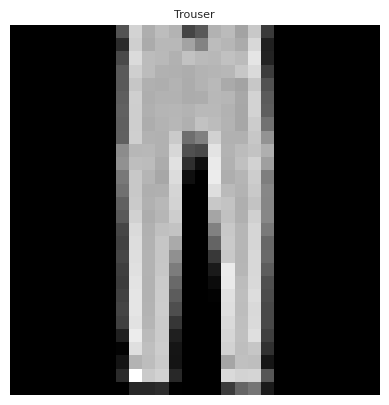

In [103]:
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label], fontsize=8)
plt.axis(False)

In [104]:
# create a flatten model
flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)  # perform the forward pass

In [105]:
print(output)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0157, 0.0000, 0.0157, 0.0039, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0039, 0.0000, 0.1490, 0.4667, 0.5098, 0.5373, 0.4941, 0.4824, 0.5137,
         0.5490, 0.5137, 0.1294, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0039,
         0.0157, 0.0000, 0.2353, 0.5255, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0235, 0.1686, 0.4745, 0.3647, 0.0000, 0.0314, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [106]:
print(f'Shape before flattening: {x.shape}')
print(f'Shape after flattening: {output.shape}')

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


# Create Model

In [107]:
import torch
from torch import nn


class FashionMNISTModel(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_classes: int):
        super().__init__()

        # Conv layers
        self._flattened_size = None
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=hidden_units, out_channels=output_classes, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces H and W by half

        # Assuming input image is 1x28x28 and conv3 keeps shape → pool reduces to 14x14
        # Output shape after conv3 + pool: output_classes x 14 x 14
        flattened_size = output_classes * 14 * 14

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=flattened_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=output_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(torch.relu(self.conv3(x)))  # shape: (batch, C, 14, 14)

        self._flattened_size = x.shape[1]

        x = x.view(x.size(0), -1)  # flatten for linear layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def describe(self, input_size=(1, 1, 28, 28)):
        x = torch.randn(*input_size)
        print("Input:", x.shape)

        x = self.conv1(x);
        print("After conv1:", x.shape)
        x = torch.relu(x)

        x = self.conv2(x);
        print("After conv2:", x.shape)
        x = torch.relu(x)

        x = self.conv3(x);
        print("After conv3:", x.shape)
        x = self.pool(x);
        print("After pool:", x.shape)

        x = x.view(x.size(0), -1);
        print("After flatten:", x.shape)



In [108]:
torch.manual_seed(101)

# Setup model with input parameters
model = FashionMNISTModel(
    input_channels=1,  # 1 channel for grayscale images
    hidden_units=32,  # hidden conv filters (tunable)
    output_classes=len(train_data.classes)  # 10 classes in FashionMNIST
)

# Describe the model architecture step-by-step
model.describe(input_size=(1, 1, 28, 28))
# Try running a forward pass on a batch
sample_input = train_features_batch
sample_output = model(sample_input)

print(f"Output shape: {sample_output.shape}")


Input: torch.Size([1, 1, 28, 28])
After conv1: torch.Size([1, 32, 28, 28])
After conv2: torch.Size([1, 32, 28, 28])
After conv3: torch.Size([1, 10, 28, 28])
After pool: torch.Size([1, 10, 14, 14])
After flatten: torch.Size([1, 1960])
Output shape: torch.Size([32, 10])


In [109]:
# Move to CUDA
model.to(device)

FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1960, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [110]:
def dataloader_to_dataframe(dataloader, class_names, max_samples=1000):
    X, y = [], []
    for X_batch, y_batch in dataloader:
        X.extend(X_batch.view(X_batch.size(0), -1).cpu().numpy())
        y.extend(y_batch.cpu().numpy())
        if len(X) >= max_samples:
            break
    df = pd.DataFrame(X[:max_samples])
    df['y'] = y[:max_samples]
    df['label'] = df['y'].apply(lambda i: class_names[i])
    return df


In [111]:

@log_time
def train_model(
        model,
        train_loader,
        test_loader,
        epochs=5,
        lr=0.001,
        patience: int = 2,
        min_delta=0.0001,
        batch_size=32,
        device=device,
        df_sample=None,
):
    torch.manual_seed(42)

    logger.info("Started MLflow run with actual run_id.")

    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("steps_per_epoch", len(train_loader))
    mlflow.log_param("patience", patience)
    mlflow.log_param("min_delta", min_delta)
    mlflow.log_param("loss_fn", "CrossEntropyLoss")

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

    train_losses, eval_losses, eval_accuracies = [], [], []
    epoch_weights, epoch_biases = [], []

    best_loss = float('inf')
    best_epoch = 0
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # --- Eval ---
        model.eval()
        epoch_val_loss = 0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                epoch_val_loss += loss_fn(y_pred, y_batch).item()
                correct += (y_pred.argmax(1) == y_batch).sum().item()

            mean_val_loss = epoch_val_loss / len(test_loader)
            eval_losses.append(mean_val_loss)

            epoch_accuracy = correct / len(test_loader.dataset) * 100
            eval_accuracies.append(epoch_accuracy)
            mlflow.log_metric("val_accuracy", epoch_accuracy)

            for name, param in model.named_parameters():
                if 'weight' in name:
                    epoch_weights.append(param.detach().cpu().numpy().mean())
                elif 'bias' in name:
                    epoch_biases.append(param.detach().cpu().numpy().mean())

            if mean_val_loss < best_loss - min_delta:
                best_loss = mean_val_loss
                best_epoch = epoch
                trigger_times = 0
            else:
                trigger_times += 1
                print(f"Trigger times: {trigger_times}")
                if trigger_times >= patience:
                    print("🛑 Early stopping triggered.")
                    break

        scheduler.step(mean_val_loss)

        if epoch % 2 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(
                f'Epoch: {epoch:4} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {mean_val_loss:.4f} | LR: {current_lr:.6f}')

    # -------------------- Final Evaluation Pass --------------------
    model.eval()
    final_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            final_correct += (y_pred.argmax(1) == y_batch).sum().item()

    final_test_accuracy = final_correct / len(test_loader.dataset) * 100
    mlflow.log_metric("final_test_accuracy", final_test_accuracy)
    print(f"[RESULT] Final Test Accuracy: {final_test_accuracy:.2f}%")

    # ---------------- Export and Register ONNX Model ----------------
    timestamp = dt.datetime.now().strftime("%Y_%m_%d_%H%M%S")
    onnx_path = f"/mnt/mls/models/torch/fashionmnist_cnn_{timestamp}.onnx"

    sample_input = next(iter(train_loader))[0][:1].to(device)

    torch.onnx.export(
        model,
        args=sample_input,
        f=onnx_path,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=11
    )

    # Log ONNX file as an artifact
    mlflow.log_artifact(onnx_path, artifact_path="onnx_model")

    # Register ONNX model with MLflow model registry
    run_id = mlflow.active_run().info.run_id
    onnx_registered_name = "FashionMNIST_CNN_ONNX"
    run_artifact_path = f"runs:/{run_id}/onnx_model"

    result = mlflow.register_model(run_artifact_path, onnx_registered_name)

    # Assume df_sample has flattened image data (e.g., shape = (N, 784))
    X_df = df_sample.drop(columns=['y', 'label'])  # drop target/label columns
    X_tensor = torch.from_numpy(X_df.to_numpy()).float().reshape(-1, 1, 28, 28).to(device)

    # Run prediction to get output
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()

    # Infer MLflow signature and input example
    signature = infer_signature(X_tensor.cpu().numpy(), y_pred)
    input_example = X_tensor[0:1].cpu().numpy()  # single sample batch

    # 🔥 Load the ONNX model from disk
    onnx_model = onnx.load(onnx_path)

    # 🔐 Log model to MLflow
    mlflow.onnx.log_model(
        onnx_model=onnx_model,
        artifact_path="model",
        input_example=input_example,
        signature=signature,
        registered_model_name="FashionMNIST_CNN_ONNX"
    )

    # Tag and alias the model in the registry
    client = mlflow.tracking.MlflowClient()

    client.update_model_version(
        name=onnx_registered_name,
        version=result.version,
        description="ONNX CNN model for FashionMNIST registered by Gabe McWilliams."
    )
    client.set_registered_model_alias(
        name=onnx_registered_name,
        version=result.version,
        alias="Training"

    )

    client.set_model_version_tag(
        name=onnx_registered_name,
        version=result.version,
        key="created_by",
        value="gabe mcwilliams"
    )

    # Log final summary metrics to MLflow
    mlflow.log_metric("final_test_accuracy", final_test_accuracy)
    mlflow.log_metric("best_val_loss", best_loss)
    mlflow.log_metric("best_epoch", best_epoch)
    mlflow.log_metric("epochs_ran", epoch + 1)

    print(f"[INFO] Model saved, logged, and registered to MLflow as '{onnx_registered_name}' version {result.version}")
    mlflow.end_run()

    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies,
        'epoch_weights': epoch_weights,
        'epoch_biases': epoch_biases,
        'best_loss': best_loss,
        'best_epoch': best_epoch,
        'final_test_accuracy': final_test_accuracy,
        'trigger_times': trigger_times,
    }


In [112]:
result = \
    train_model(
        model,
        train_dataloader,
        test_dataloader,
        epochs=10000,
        patience=3,
        lr=0.001,
        df_sample=dataloader_to_dataframe(train_dataloader, train_data.classes)

    )

Epoch:    0 | Train Loss: 796.0896 | Val Loss: 0.3211 | LR: 0.001000
Epoch:    2 | Train Loss: 427.1691 | Val Loss: 0.2498 | LR: 0.001000
Epoch:    4 | Train Loss: 321.0572 | Val Loss: 0.2266 | LR: 0.001000
Trigger times: 1
Trigger times: 2
Epoch:    6 | Train Loss: 247.2387 | Val Loss: 0.2483 | LR: 0.001000
Trigger times: 3
🛑 Early stopping triggered.


Registered model 'FashionMNIST_CNN_ONNX' already exists. Creating a new version of this model...
2025/05/08 07:23:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FashionMNIST_CNN_ONNX, version 34


[RESULT] Final Test Accuracy: 91.92%


Created version '34' of model 'FashionMNIST_CNN_ONNX'.
Registered model 'FashionMNIST_CNN_ONNX' already exists. Creating a new version of this model...
2025/05/08 07:23:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FashionMNIST_CNN_ONNX, version 35


[INFO] Model saved, logged, and registered to MLflow as 'FashionMNIST_CNN_ONNX' version 34
🏃 View run rogue-fawn-913 at: https://mlflow.example.internal/#/experiments/4/runs/1cf7d708b7d94d009e0d73f86fe2086c
🧪 View experiment at: https://mlflow.example.internal/#/experiments/4


Created version '35' of model 'FashionMNIST_CNN_ONNX'.


In [113]:
dataloader_to_dataframe(train_dataloader, train_data.classes)

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,y,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.294118,0.674510,0.082353,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,2,Pullover
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,...,0.282353,0.066667,0.000000,0.011765,0.00000,0.0,0.0,0.0,0,T-shirt/top
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,8,Bag
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.007843,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,6,Shirt
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,5,Sandal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.086275,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,3,Dress
996,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.227451,...,0.431373,0.039216,0.000000,0.000000,0.00000,0.0,0.0,0.0,3,Dress
997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.352941,0.709804,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,1,Trouser
998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007843,0.007843,0.000000,...,0.000000,0.074510,0.560784,0.533333,0.12549,0.0,0.0,0.0,4,Coat


In [114]:
result

{'train_losses': [0.4245811359008153,
  0.2707964230954647,
  0.22782354320983092,
  0.1953738783195615,
  0.17123051351457835,
  0.14881675257980823,
  0.13186062223489087,
  0.11438926393482834],
 'eval_losses': [0.32107864546414,
  0.2762843522484215,
  0.24980528461047635,
  0.23983793520925048,
  0.22660777596429513,
  0.24641431318804288,
  0.24833317975195263,
  0.25657911892658986],
 'eval_accuracies': [88.26,
  89.82,
  90.75999999999999,
  91.63,
  92.10000000000001,
  91.64,
  92.02,
  91.92],
 'epoch_weights': [-0.026174992,
  -0.0027321386,
  -0.009482773,
  -0.0026652045,
  -0.008026844,
  -0.044567917,
  -0.006658461,
  -0.015352308,
  -0.0029601217,
  -0.012314925,
  -0.05541712,
  -0.010159567,
  -0.018272247,
  -0.0036109895,
  -0.016226742,
  -0.05810155,
  -0.013214301,
  -0.02044933,
  -0.0038165853,
  -0.019353898,
  -0.061608918,
  -0.015373319,
  -0.022052193,
  -0.004171861,
  -0.02304392,
  -0.06651941,
  -0.016409365,
  -0.025792092,
  -0.004480328,
  -0.0257

In [115]:
def plot_metrics(train_losses, test_losses, accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.title('Test Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


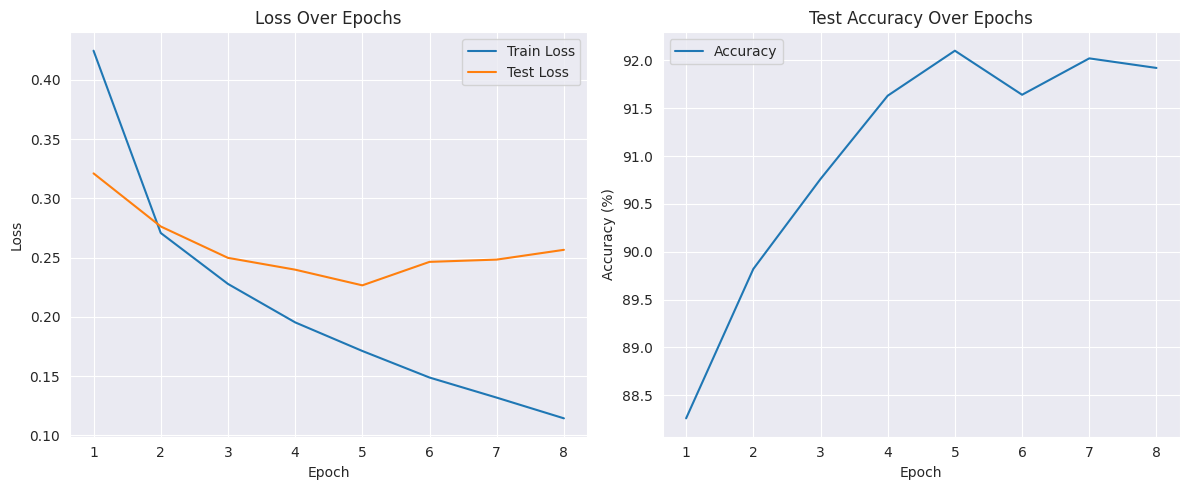

In [116]:
plot_metrics(
    train_losses=result['train_losses'],
    test_losses=result['eval_losses'],
    accuracies=result['eval_accuracies']
)

In [117]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot it
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


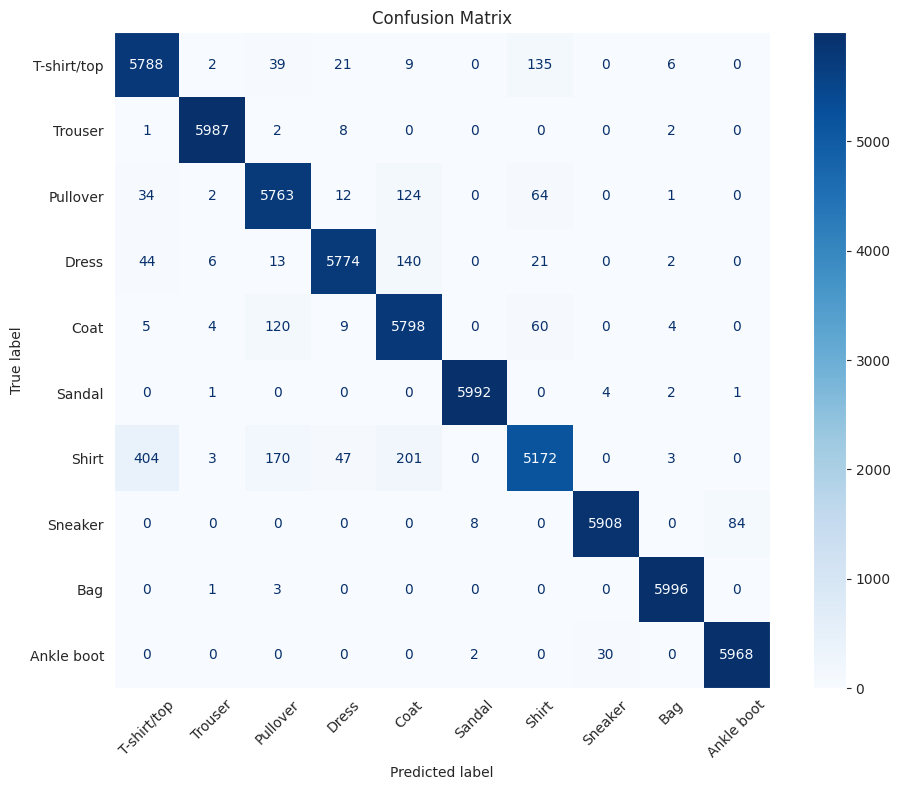

In [118]:
plot_confusion_matrix(
    model=model,
    dataloader=train_dataloader,
    class_names=train_data.classes,
    device=device,
)

In [119]:
def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # row-normalized
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()


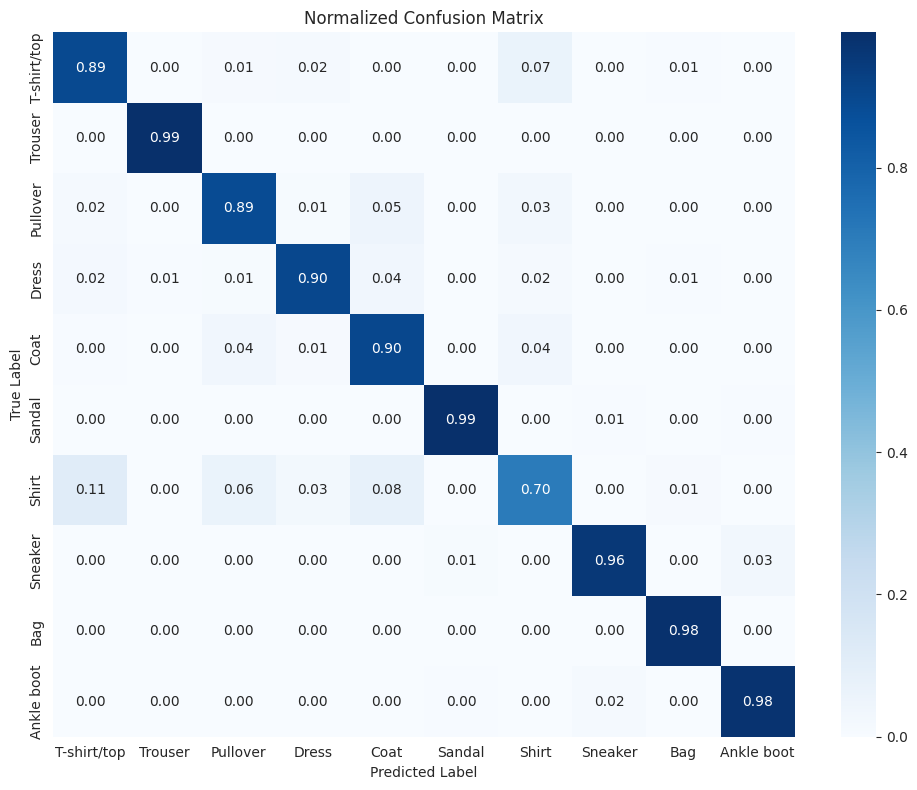

In [120]:
# Assuming your test set is already prepared and predictions are made
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_logits = model(X_batch)
        y_preds = y_logits.argmax(dim=1)
        all_preds.extend(y_preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

plot_normalized_confusion_matrix(
    y_true=all_labels,
    y_pred=all_preds,
    class_names=train_data.classes
)

In [121]:
torch.save(model.state_dict(), "/mnt/mls/models/torch/fashionmnist_cnn.pth")